In [31]:
from astropy.table import QTable, Table
#from astropy.io import fits

import numpy as np

import sys

sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from dark_matter_mass_v1 import rot_fit_BB
#from Pipe3D_rotation_curve import extract_data
#from Pipe3D_rotation_curve_functions import build_mask

#sys.path.insert(2, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/')
#from mapSmoothness_functions import how_smooth

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
%matplotlib notebook

## Pipe3d Galaxy data

In [33]:
galaxies = QTable.read('../spirals/Pipe3D-master_file_vflag_10_smooth.txt', format='ascii.ecsv')

<IPython.core.display.Javascript object>


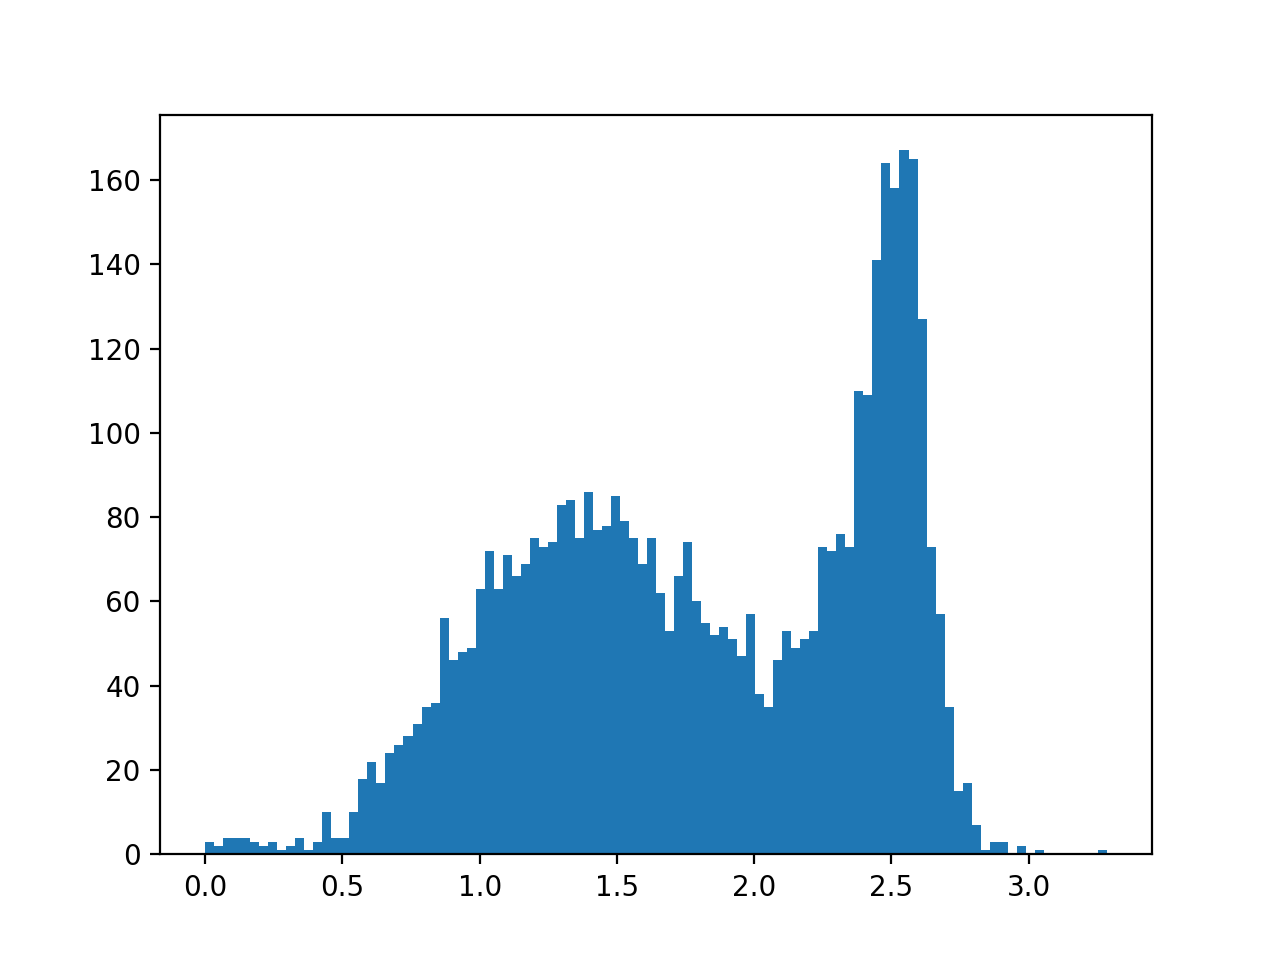

In [34]:
plt.figure()

plt.hist(galaxies['smoothness_score'], bins=100);

# DRP galaxy data

In [3]:
#galaxies_DRP = QTable.read('../spirals/DRPall-master_file.txt', format='ascii.ecsv')
galaxies_DRP = Table.read('../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_v6.txt', 
                          format='ascii.commented_header')

In [10]:
################################################################################
# Calculate the velocity at R90, Rmax
#-------------------------------------------------------------------------------
# Convert r from arcsec to kpc
#-------------------------------------------------------------------------------
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

dist_to_galaxy_Mpc = c*galaxies_DRP['NSA_redshift']/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

galaxies_DRP['R90_kpc'] = dist_to_galaxy_kpc*np.tan(galaxies_DRP['NSA_elpetro_th90']*(1./60)*(1./60)*(np.pi/180))
#-------------------------------------------------------------------------------

galaxies_DRP['V90_kms'] = rot_fit_BB(galaxies_DRP['R90_kpc'], 
                             [galaxies_DRP['Vmax_map'], 
                              galaxies_DRP['Rturn_map'], 
                              galaxies_DRP['alpha_map']])

galaxies_DRP['VRmax_kms'] = rot_fit_BB(galaxies_DRP['Rmax_map'], 
                               [galaxies_DRP['Vmax_map'], 
                                galaxies_DRP['Rturn_map'], 
                                galaxies_DRP['alpha_map']])
################################################################################


bad_boolean = np.logical_or.reduce([np.isnan(galaxies_DRP['M90_map']), 
                                    np.isnan(galaxies_DRP['M90_disk_map']), 
                                    galaxies_DRP['alpha_map'] > 99, 
                                    galaxies_DRP['ba_map'] > 0.998, 
                                    galaxies_DRP['V90_kms']/galaxies_DRP['Vmax_map'] < 0.9, 
                                    (galaxies_DRP['Tidal'] & (galaxies_DRP['DL_merge'] > 0.97)), 
                                    galaxies_DRP['map_frac_unmasked'] < 0.05])

good_galaxies = galaxies_DRP[~bad_boolean]

/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


<IPython.core.display.Javascript object>


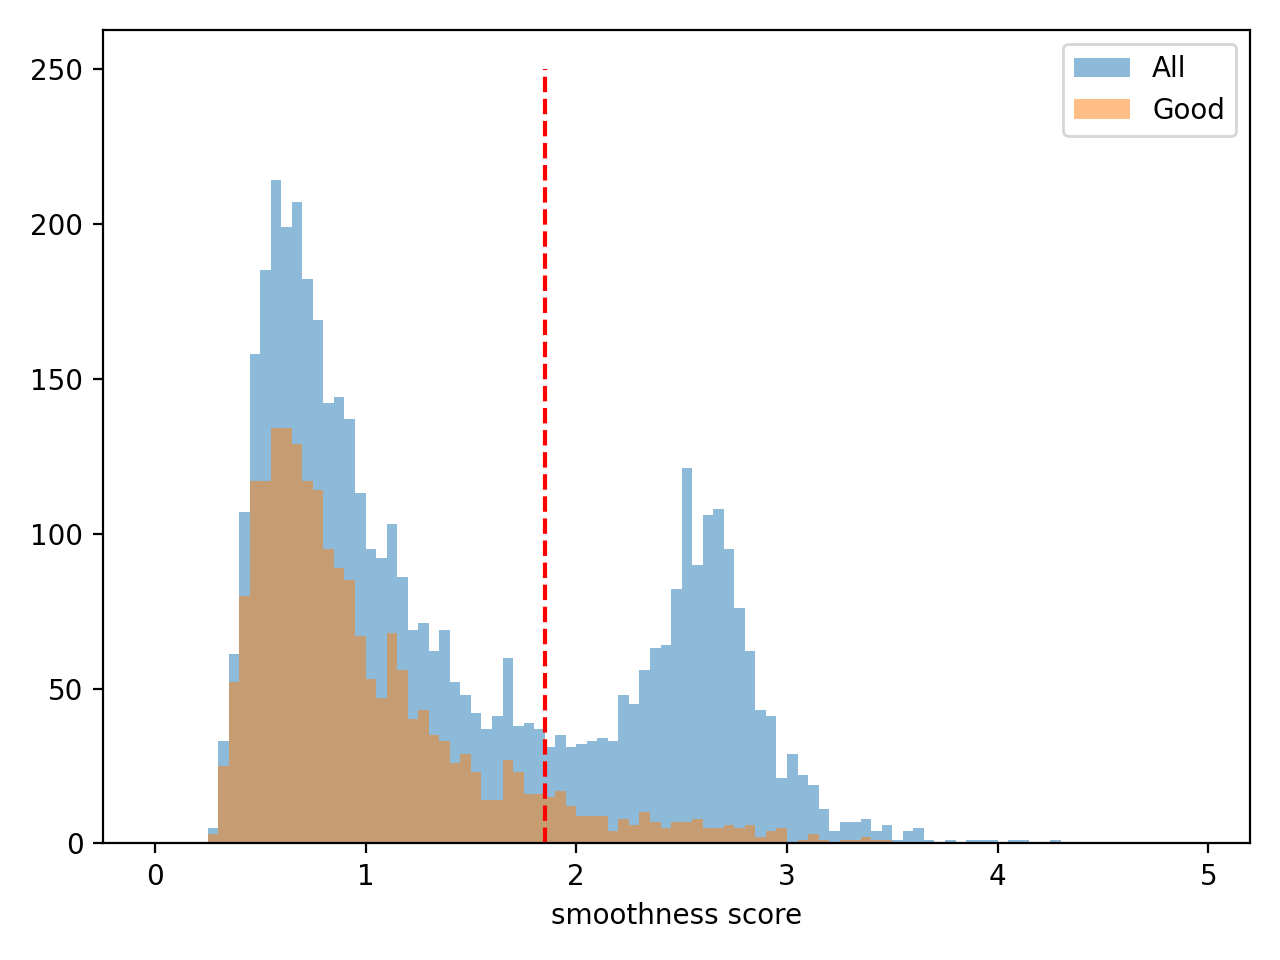

In [15]:
plt.figure()

#plt.hist(galaxies_DRP['smoothness_score'], bins=100);
plt.hist(galaxies_DRP['DRP_map_smoothness'], bins=np.arange(0,5,0.05), alpha=0.5, label='All')
plt.hist(good_galaxies['DRP_map_smoothness'], bins=np.arange(0,5,0.05), alpha=0.5, label='Good')

plt.vlines(1.85, 0,250, colors='r', linestyles='dashed')

plt.xlabel('smoothness score')

plt.legend()

plt.tight_layout();

In [57]:
bad_boolean = np.logical_or.reduce([(good_galaxies['map_frac_unmasked'] > 0.13) & (good_galaxies['DRP_map_smoothness'] > 1.96), 
                                    (good_galaxies['map_frac_unmasked'] > 0.07) & (good_galaxies['DRP_map_smoothness'] > 2.9), 
                                    (good_galaxies['map_frac_unmasked'] > -0.0638*good_galaxies['DRP_map_smoothness'] + 0.255) & (good_galaxies['DRP_map_smoothness'] > 1.96)])

<IPython.core.display.Javascript object>


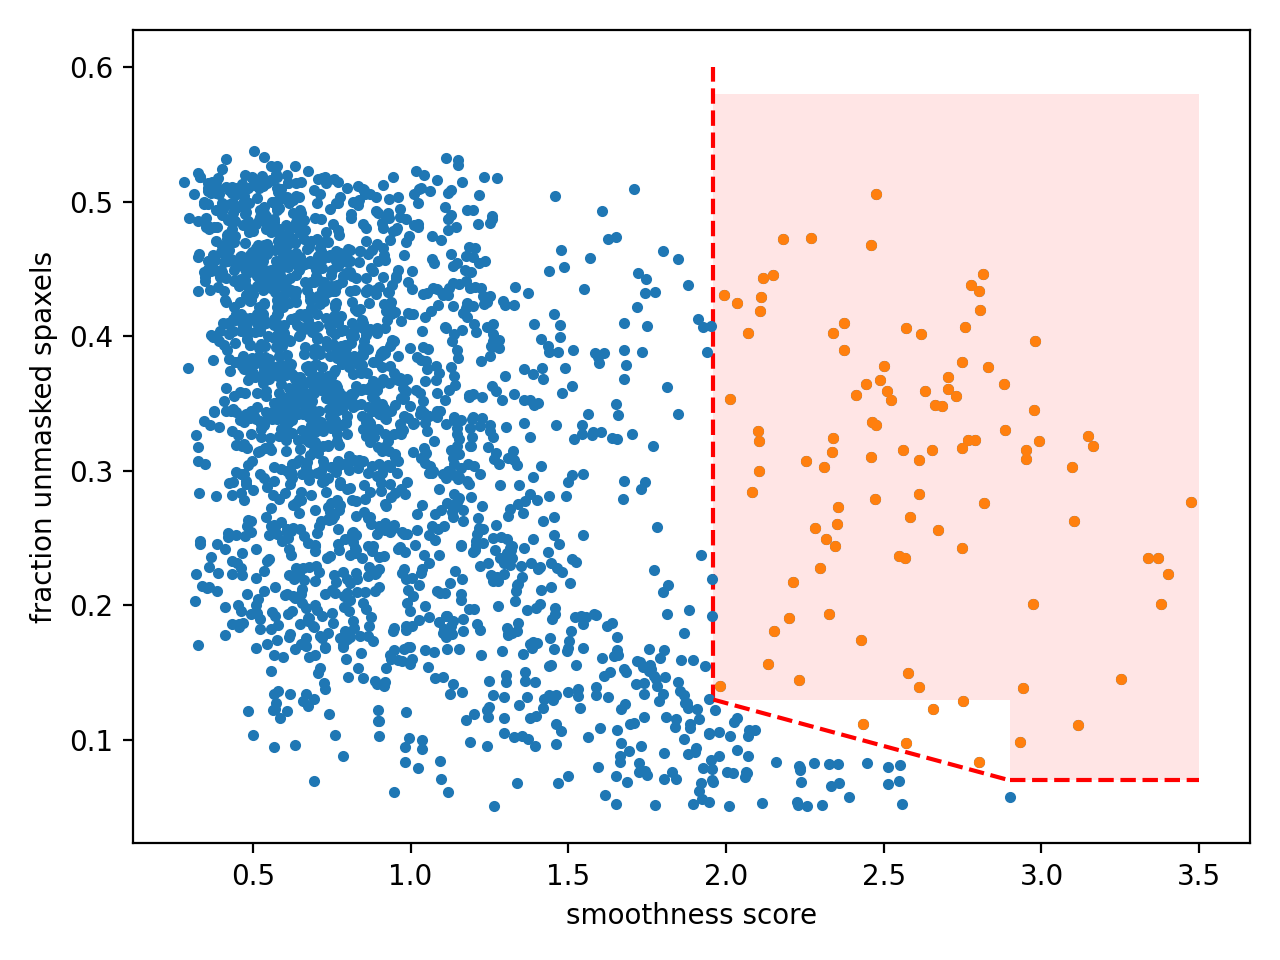

In [58]:
fig, ax = plt.subplots(1)

save1 = Rectangle((1.85,0), 1.96-1.85, 0.6)
remove1 = Rectangle((1.96,0.13), 3.5-1.96, 0.45)
remove2 = Rectangle((2.9, 0.07), 3.5-2.9, 0.13-0.07)

pc = PatchCollection([remove1, remove2], facecolor='r', alpha=0.1, edgecolor='none')

ax.add_collection(pc)

plt.plot(good_galaxies['DRP_map_smoothness'], good_galaxies['map_frac_unmasked'], '.')

plt.plot(good_galaxies['DRP_map_smoothness'][bad_boolean], 
         good_galaxies['map_frac_unmasked'][bad_boolean], 
         '.')

plt.vlines(1.96, 0.13,0.6, colors='r', linestyles='dashed')
plt.hlines(0.07, 2.9,3.5, colors='r', linestyles='dashed')
plt.plot([1.96, 2.9], [0.13,0.07], 'r--')

plt.xlabel('smoothness score')
plt.ylabel('fraction unmasked spaxels')

plt.tight_layout();

In [44]:
good_galaxies[['MaNGA_plate', 'MaNGA_IFU', 'map_frac_unmasked', 'DRP_map_smoothness', 'map_fit_flag']][(good_galaxies['DRP_map_smoothness'] > 1.96) & \
                                                                                                       (good_galaxies['map_frac_unmasked'] < 0.21)].show_in_notebook()

idx,MaNGA_plate,MaNGA_IFU,map_frac_unmasked,DRP_map_smoothness,map_fit_flag
0,8728,6101,0.144718792866941,2.2316606613685344,-4.0
1,9033,3701,0.051587301587301584,2.305170694986979,5.0
2,8243,6103,0.13854595336076816,2.9403634765625,-4.0
3,7495,3704,0.057334710743801656,2.901382810833511,5.0
4,8984,3703,0.11105371900826447,3.116769949021322,-4.0
5,7975,12701,0.08795013850415513,1.9791254191638128,5.0
6,8320,1902,0.12283737024221453,2.6557875329021057,-4.0
7,8083,1902,0.201171875,2.972445309817136,-4.0
8,9049,3703,0.0691609977324263,2.2367820836812182,5.0
9,9044,6102,0.1289437585733882,2.7512410851009528,-4.0
